
## Prodigy Infotech

### Author : Rudra Patel


### Data Science
### Task-05

#### Task : Analyze traffic accident data to identify patterns related to road conditions, weather, and time of day. Visualize accident hotspots and contributing factors.

### DataSet Link: https://www.kaggle.com/code/harshalbhamare/us-accident-eda


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fastparquet import ParquetFile
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

In [ ]:
data = ParquetFile("US_Accidents_2019_March23.parquet").to_pandas()
data = data.drop("year", axis=1)
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-512230,Source2,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,NaN,NaN,0.00,Crash on CR-11 Army Trail Rd at IL-59.,Army Trail Rd,Bartlett,DuPage,IL,60103,US,US/Central,KDPA,2022-09-08 05:52:00,58.0,58.0,90.0,29.24,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
1,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.00,Crash on CA-138 Pearblossom Hwy at 96th St.,Pearblossom Hwy,Littlerock,Los Angeles,CA,93543,US,US/Pacific,KPMD,2022-09-08 01:53:00,86.0,86.0,28.0,27.35,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-512232,Source2,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,NaN,NaN,0.00,Crash on 2nd St Northbound at Franklin St.,N 2nd St,Richmond,Richmond City,VA,23219,US,US/Eastern,KRIC,2022-09-08 05:16:00,68.0,68.0,96.0,29.71,10.0,N,8.0,0.0,Mostly Cloudy,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night
3,A-512233,Source2,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,NaN,NaN,0.00,Crash on US-62 Atlantic Blvd Westbound after O...,Atlantic Blvd NE,Alliance,Stark,OH,44601,US,US/Eastern,KCAK,2022-09-08 06:51:00,62.0,62.0,86.0,28.71,7.0,NNE,6.0,0.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-512234,Source2,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,NaN,NaN,1.91,Crash on entry ramp to I-77 Northbound at Exit...,I-77 N,Independence,Cuyahoga,OH,44131,US,US/Eastern,KBKL,2022-09-08 06:53:00,63.0,63.0,87.0,29.37,7.0,SSE,3.0,0.0,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day


## Data Exploration :

In [ ]:
#Checking the dimension of the training dataset:
print("The total rows in the dataset is:" ,data.shape[0] ,"\nThe total columns in the dataset is:" ,data.shape[1])

The total rows in the dataset is: 5706118 
The total columns in the dataset is: 46


In [ ]:
#Converting into date time format:
data['Start_Time'] = pd.to_datetime(data["Start_Time"], errors="coerce")
data['End_Time'] = pd.to_datetime(data["End_Time"], errors="coerce")
data["Year"]=data["Start_Time"].dt.year
data["Severity"]=data["Severity"].apply(lambda x : str(x))
data["Hour"]=data["Start_Time"].dt.hour
data["Month"]=data["Start_Time"].dt.month
data["Day"]=data["Start_Time"].dt.day_name()
data['Time_of_Year'] = data['Start_Time'].dt.quarter
data['Duration'] = data['End_Time'] - data['Start_Time']
data['Duration_in_minutes'] = data['Duration'].dt.total_seconds() / 60
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Hour,Month,Day,Time_of_Year,Duration,Duration_in_minutes
0,A-512230,Source2,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,NaN,NaN,0.00,Crash on CR-11 Army Trail Rd at IL-59.,Army Trail Rd,Bartlett,DuPage,IL,60103,US,US/Central,KDPA,2022-09-08 05:52:00,58.0,58.0,90.0,29.24,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,2022,5,9,Thursday,3,0 days 00:45:23,45.383333
1,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.00,Crash on CA-138 Pearblossom Hwy at 96th St.,Pearblossom Hwy,Littlerock,Los Angeles,CA,93543,US,US/Pacific,KPMD,2022-09-08 01:53:00,86.0,86.0,28.0,27.35,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,2,9,Thursday,3,0 days 02:29:27,149.450000
2,A-512232,Source2,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,NaN,NaN,0.00,Crash on 2nd St Northbound at Franklin St.,N 2nd St,Richmond,Richmond City,VA,23219,US,US/Eastern,KRIC,2022-09-08 05:16:00,68.0,68.0,96.0,29.71,10.0,N,8.0,0.0,Mostly Cloudy,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2022,5,9,Thursday,3,0 days 02:24:05,144.083333
3,A-512233,Source2,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,NaN,NaN,0.00,Crash on US-62 Atlantic Blvd Westbound after O...,Atlantic Blvd NE,Alliance,Stark,OH,44601,US,US/Eastern,KCAK,2022-09-08 06:51:00,62.0,62.0,86.0,28.71,7.0,NNE,6.0,0.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day,2022,6,9,Thursday,3,0 days 00:29:45,29.750000
4,A-512234,Source2,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,NaN,NaN,1.91,Crash on entry ramp to I-77 Northbound at Exit...,I-77 N,Independence,Cuyahoga,OH,44131,US,US/Eastern,KBKL,2022-09-08 06:53:00,63.0,63.0,87.0,29.37,7.0,SSE,3.0,0.0,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,2022,6,9,Thursday,3,0 days 00:29:38,29.633333


In [ ]:
# Checking the type of data in each column:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5706118 entries, 0 to 5706117
Data columns (total 53 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   ID                     object         
 1   Source                 object         
 2   Severity               object         
 3   Start_Time             datetime64[ns] 
 4   End_Time               datetime64[ns] 
 5   Start_Lat              float64        
 6   Start_Lng              float64        
 7   End_Lat                float64        
 8   End_Lng                float64        
 9   Distance(mi)           float64        
 10  Description            object         
 11  Street                 object         
 12  City                   object         
 13  County                 object         
 14  State                  object         
 15  Zipcode                object         
 16  Country                object         
 17  Timezone               object         
 18  Ai

In [ ]:
# Calculating the number of categorical and numeric column:
data.dtypes.value_counts()

object             20
float64            13
bool               13
int32               4
datetime64[ns]      2
timedelta64[ns]     1
Name: count, dtype: int64

In [ ]:
#checking for missing values
data.isna().sum().sort_values(ascending = False)

End_Lat                  1848455
End_Lng                  1848455
Precipitation(in)         423004
Wind_Chill(F)             294422
Wind_Speed(mph)           190250
Wind_Direction            150129
Humidity(%)               133266
Visibility(mi)            129912
Weather_Condition         125831
Temperature(F)            125004
Pressure(in)              106359
Weather_Timestamp          95264
Astronomical_Twilight      23162
Nautical_Twilight          23162
Sunrise_Sunset             23162
Civil_Twilight             23162
Airport_Code               19311
Street                     10863
Timezone                    6133
Zipcode                     1414
City                         189
Description                    5
Railway                        0
Year                           0
Hour                           0
Month                          0
Day                            0
Time_of_Year                   0
Duration                       0
Turning_Loop                   0
Traffic_Si

In [ ]:
#Descriptive Analysis
data.describe()

,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Hour,Month,Time_of_Year,Duration,Duration_in_minutes
count,5706118,5706118,5.706118e+06,5.706118e+06,3.857663e+06,3.857663e+06,5.706118e+06,5.581114e+06,5.411696e+06,5.572852e+06,5.599759e+06,5.576206e+06,5.515868e+06,5.283114e+06,5.706118e+06,5.706118e+06,5.706118e+06,5.706118e+06,5706118,5.706118e+06
mean,2021-05-10 14:56:18.632039424,2021-05-11 00:10:52.146717184,3.613018e+01,-9.465425e+01,3.614318e+01,-9.569704e+01,6.621090e-01,6.115010e+01,5.997236e+01,6.456485e+01,2.936739e+01,9.055361e+00,7.361827e+00,5.964566e-03,2.020854e+03,1.236897e+01,6.538462e+00,2.509831e+00,0 days 09:14:33.514677321,5.545586e+02
min,2016-10-21 07:26:00,2019-01-01 00:00:06,2.455480e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0 days 00:02:00,2.000000e+00
25%,2020-06-10 17:17:03,2020-06-10 18:36:43.249999872,3.337536e+01,-1.172397e+02,3.338314e+01,-1.177576e+02,0.000000e+00,4.800000e+01,4.700000e+01,4.800000e+01,2.918000e+01,1.000000e+01,3.000000e+00,0.000000e+00,2.020000e+03,8.000000e+00,3.000000e+00,1.000000e+00,0 days 00:46:14,4.623333e+01
50%,2021-06-30 13:29:48.500000,2021-06-30 21:56:06,3.582418e+01,-8.727377e+01,3.609557e+01,-8.795404e+01,9.200000e-02,6.300000e+01,6.400000e+01,6.700000e+01,2.970000e+01,1.000000e+01,7.000000e+00,0.000000e+00,2.021000e+03,1.300000e+01,6.000000e+00,2.000000e+00,0 days 01:18:50,7.883333e+01
75%,2022-04-22 17:22:51,2022-04-23 10:03:23.500000,4.002096e+01,-8.031294e+01,4.007139e+01,-8.022521e+01,6.300000e-01,7.600000e+01,7.600000e+01,8.400000e+01,2.996000e+01,1.000000e+01,1.000000e+01,0.000000e+00,2.022000e+03,1.700000e+01,1.000000e+01,4.000000e+00,0 days 02:07:41,1.276833e+02
max,2023-03-31 23:30:00,2023-03-31 23:59:00,4.900220e+01,-6.748413e+01,4.900222e+01,-6.748413e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01,2.023000e+03,2.300000e+01,1.200000e+01,4.000000e+00,1953 days 10:19:00,2.812939e+06
std,NaN,NaN,5.117059e+00,1.748885e+01,5.282789e+00,1.814234e+01,1.860785e+00,1.920046e+01,2.151782e+01,2.293677e+01,1.110186e+00,2.606414e+00,5.509161e+00,5.326329e-02,1.155935e+00,5.597124e+00,3.707903e+00,1.173847e+00,10 days 19:30:04.047683052,1.557007e+04


## Insights
- There is a clear reduction in the number of accidents at weekends.
- January has the highest proportion of weekend accidents compared with weekday accidents, at 17.71%.
- Augusth has the lowest proportion of weekend accidents, at 3.258%
- December has the highest number of accidents.
- July has the lowest number of accidents.ts.

## Data Preprocessing

In [ ]:
# The percentage share of missing values for each column in the entire data
missing_percentage = data.isna().sum().sort_values(ascending = False)/len(data)
missing_percentage
#sort out the ones with zeroes
missing_percentage[missing_percentage != 0]

End_Lat                  3.239427e-01
End_Lng                  3.239427e-01
Precipitation(in)        7.413166e-02
Wind_Chill(F)            5.159760e-02
Wind_Speed(mph)          3.334141e-02
Wind_Direction           2.631018e-02
Humidity(%)              2.335493e-02
Visibility(mi)           2.276714e-02
Weather_Condition        2.205194e-02
Temperature(F)           2.190701e-02
Pressure(in)             1.863947e-02
Weather_Timestamp        1.669506e-02
Astronomical_Twilight    4.059152e-03
Nautical_Twilight        4.059152e-03
Sunrise_Sunset           4.059152e-03
Civil_Twilight           4.059152e-03
Airport_Code             3.384262e-03
Street                   1.903746e-03
Timezone                 1.074811e-03
Zipcode                  2.478042e-04
City                     3.312234e-05
Description              8.762525e-07
dtype: float64

In [ ]:
# Percentage of missing value
missing_values = data.isna().sum().sort_values(ascending=False)
missing_percentage = missing_values[missing_values!=0]/len(data)*100
print(" Percentage of Missing Values \n", missing_percentage)

 Percentage of Missing Values 
 End_Lat                  32.394265
End_Lng                  32.394265
Precipitation(in)         7.413166
Wind_Chill(F)             5.159760
Wind_Speed(mph)           3.334141
Wind_Direction            2.631018
Humidity(%)               2.335493
Visibility(mi)            2.276714
Weather_Condition         2.205194
Temperature(F)            2.190701
Pressure(in)              1.863947
Weather_Timestamp         1.669506
Astronomical_Twilight     0.405915
Nautical_Twilight         0.405915
Sunrise_Sunset            0.405915
Civil_Twilight            0.405915
Airport_Code              0.338426
Street                    0.190375
Timezone                  0.107481
Zipcode                   0.024780
City                      0.003312
Description               0.000088
dtype: float64


In [ ]:
data.drop(["End_Lat"],axis=1,inplace=True)
data.drop(["End_Lng"],axis=1,inplace=True)
data.drop(["Precipitation(in)"],axis=1,inplace=True)
data.drop(["Wind_Chill(F)"],axis=1,inplace=True)
print(len(data.columns))

49


In [ ]:
# List of Columns Having Null Values
null_cols = [i for i in data.columns if data[i].isnull().any()]
print(null_cols)

['Description', 'Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


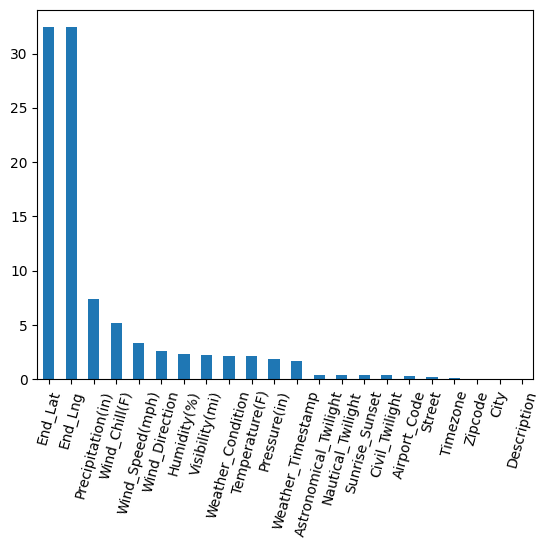

In [ ]:
missing_percentage[missing_percentage != 0].plot(kind = "bar");
plt.xticks(rotation=75);
plt.show()

In [ ]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year',
       'Hour', 'Month', 'Day', 'Time_of_Year', 'Duration',
       'Duration_in_minutes'],
      dtype='object')

## Insights:
- Our dataset has  many missing values.
- We can see that the column End_Lat, End_Lng, Wind_Chill(F) and Precipitation(in) have highest percentage of missing values. In this case it is better to remove those columns instead of filling them with average values or 0.
- After dropping the above columns with greater percentage of missing value we have 46 columns.
- All columns are not important for our analysis, so we are removing the columns which are least important.

## EDA and visualization
- Some basic analysis
- Analysing by time
- Analysing by weather
- Analysing by road


<Axes: xlabel='Severity', ylabel='count'>

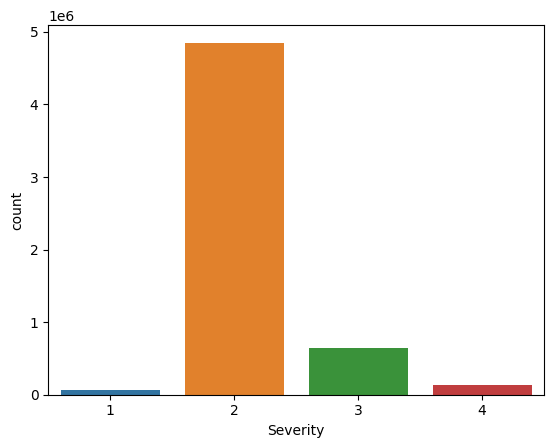

In [ ]:
# Plotting the 'subscribed' frequency
sns.countplot(data=data, x='Severity')

#### To analyse what is the most frequent "Severity" level for accidents and Which locations have the most accidents in the USA¶

In [ ]:
crosstab=pd.crosstab(data["Timezone"],data["Severity"])
crosstab

Severity,1,2,3,4
Timezone,,,,
US/Central,12176,927868,187567,22769
US/Eastern,31437,2260111,295843,89887
US/Mountain,10096,282440,39502,11167
US/Pacific,12811,1373758,126088,16465


sns.set_palette("Set2")
crosstab.plot(kind="bar",stacked=True, figsize=(8,8), rot=45, fontsize=10)
plt.xlabel("US Timezones",fontsize=14)
plt.ylabel("No. Of Accidents",fontsize=14)
plt.show()

US/Eastern has the greatest accident followed by US/Pacific timezone. US/Mountain has the least accident.

 #### Citywise Accidents in USA

In [ ]:
cities = data.City.unique()
len(cities)

12925

In [ ]:
#Showing no. of accidents in dfferent cities

cities_by_accidents = data.City.value_counts().sort_values(ascending = False)
cities_by_accidents

City
Miami                           163876
Los Angeles                     110272
Houston                          98482
Charlotte                        92394
Orlando                          89123
                                 ...  
Hudson Oaks                          1
Kewaunee                             1
Grahamsville                         1
Bristolville                         1
American Fork-Pleasant Grove         1
Name: count, Length: 12924, dtype: int64

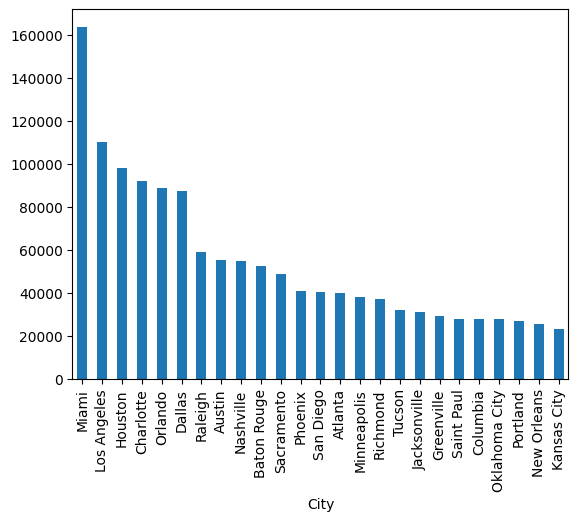

In [ ]:
# Showing Top 25 cities with highest no. of accidents

cities_by_accidents[:25].plot(kind = 'bar');
plt.xticks(rotation=90)
plt.show()

In [ ]:
high_accident_cities = cities_by_accidents[cities_by_accidents >=1000];
low_accident_cities = cities_by_accidents[cities_by_accidents < 1000];
print("No. of cities with high accidents are {}".format(len(high_accident_cities)))
print("Percentage of cities with high accidents are {}".format((len(high_accident_cities)/len(cities))*100))
print("No. of cities with low accidents are {}".format(len(low_accident_cities)))
print("Percentage of cities with low accidents are {}".format((len(low_accident_cities)/len(cities))*100))

No. of cities with high accidents are 972
Percentage of cities with high accidents are 7.520309477756286
No. of cities with low accidents are 11952
Percentage of cities with low accidents are 92.47195357833655


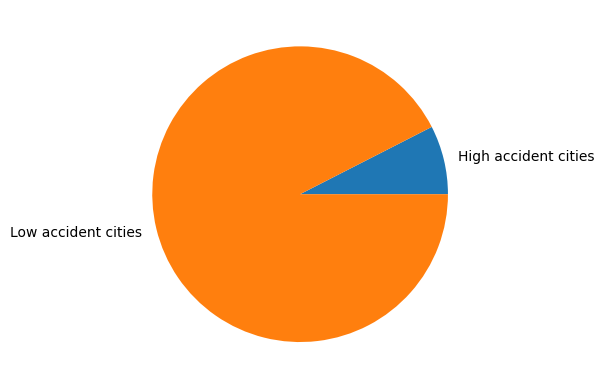

In [ ]:
High_accident_zone = (len(high_accident_cities)/len(cities))*100
Low_accident_zone = (len(low_accident_cities)/len(cities))*100
y = np.array([High_accident_zone,Low_accident_zone])
mylabels = np.array(["High accident cities", "Low accident cities"])
plt.pie(y, labels = mylabels);
plt.show()

## Insights:
- Most of the accidents are of severity 2.
- US/Eastern has the greatest accident followed by US/Pacific timezone. US/Mountain has the least accident.
- Miami, Houston, Los Angeles, Charlotte, Dallas are some of the cities with highest no. of accidents reccorded.
-  Percentage of cities with high accidents are 8.904159660793917 .
-  Percentage of cities with low accidents are 91.0885298632941.
-  Low accident cities are more than high accident cities
(
Here,High accidents means no.of accidents more than 1000 in the 7 years and Low accidents means no.of accidents less than 1000 in the 7 years(2016-202)3).

## Analysing by time

#### Weekly accident analysis

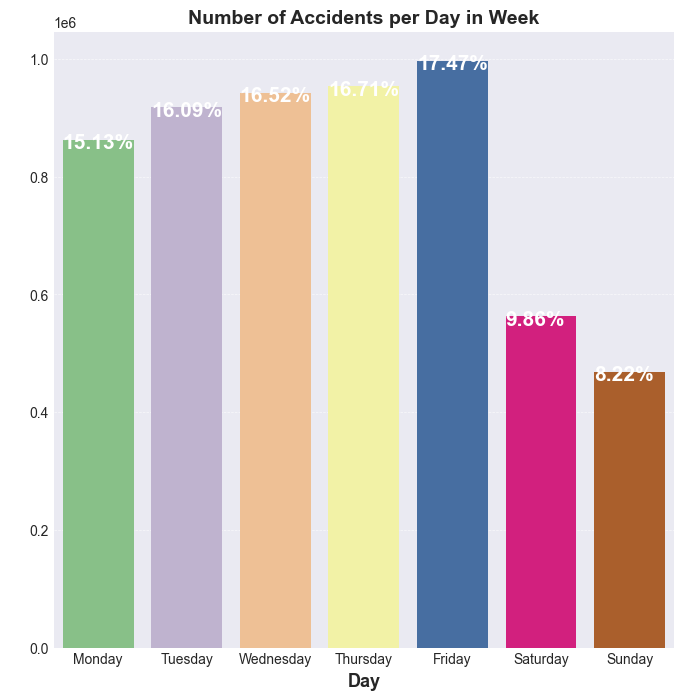

In [ ]:
plt.style.use('seaborn-dark')

custom_palette = sns.color_palette("Accent", 7)

# Change the default color palette to the custom palette
sns.set_palette(custom_palette)

plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=data["Day"], order=order)

# Calculate the total counts
total_counts = data["Day"].value_counts()

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Day", fontsize=13, fontweight="bold")
plt.ylabel(" ")
plt.title("Number of Accidents per Day in Week", fontsize=14, fontweight="bold")

ax = plt.gca()

for i, bar in enumerate(ax.patches):
    proportion = (total_counts[order[i]]/total_counts.sum()) * 100
    ax.text(
        bar.get_x(),
        bar.get_height()-15000,
        f'{proportion:.2f}%',
        fontsize=15,
        weight='bold',
        color='white'
    )

plt.show()

#### From the above analysis we can see that the number of accidents on weekends are less. Analysing if the accident rate on weekends less throghout the year.

In [ ]:
data["Is_Weekend"] = data["Day"].isin(["Saturday", "Sunday"])

In [ ]:
sns.reset_defaults()

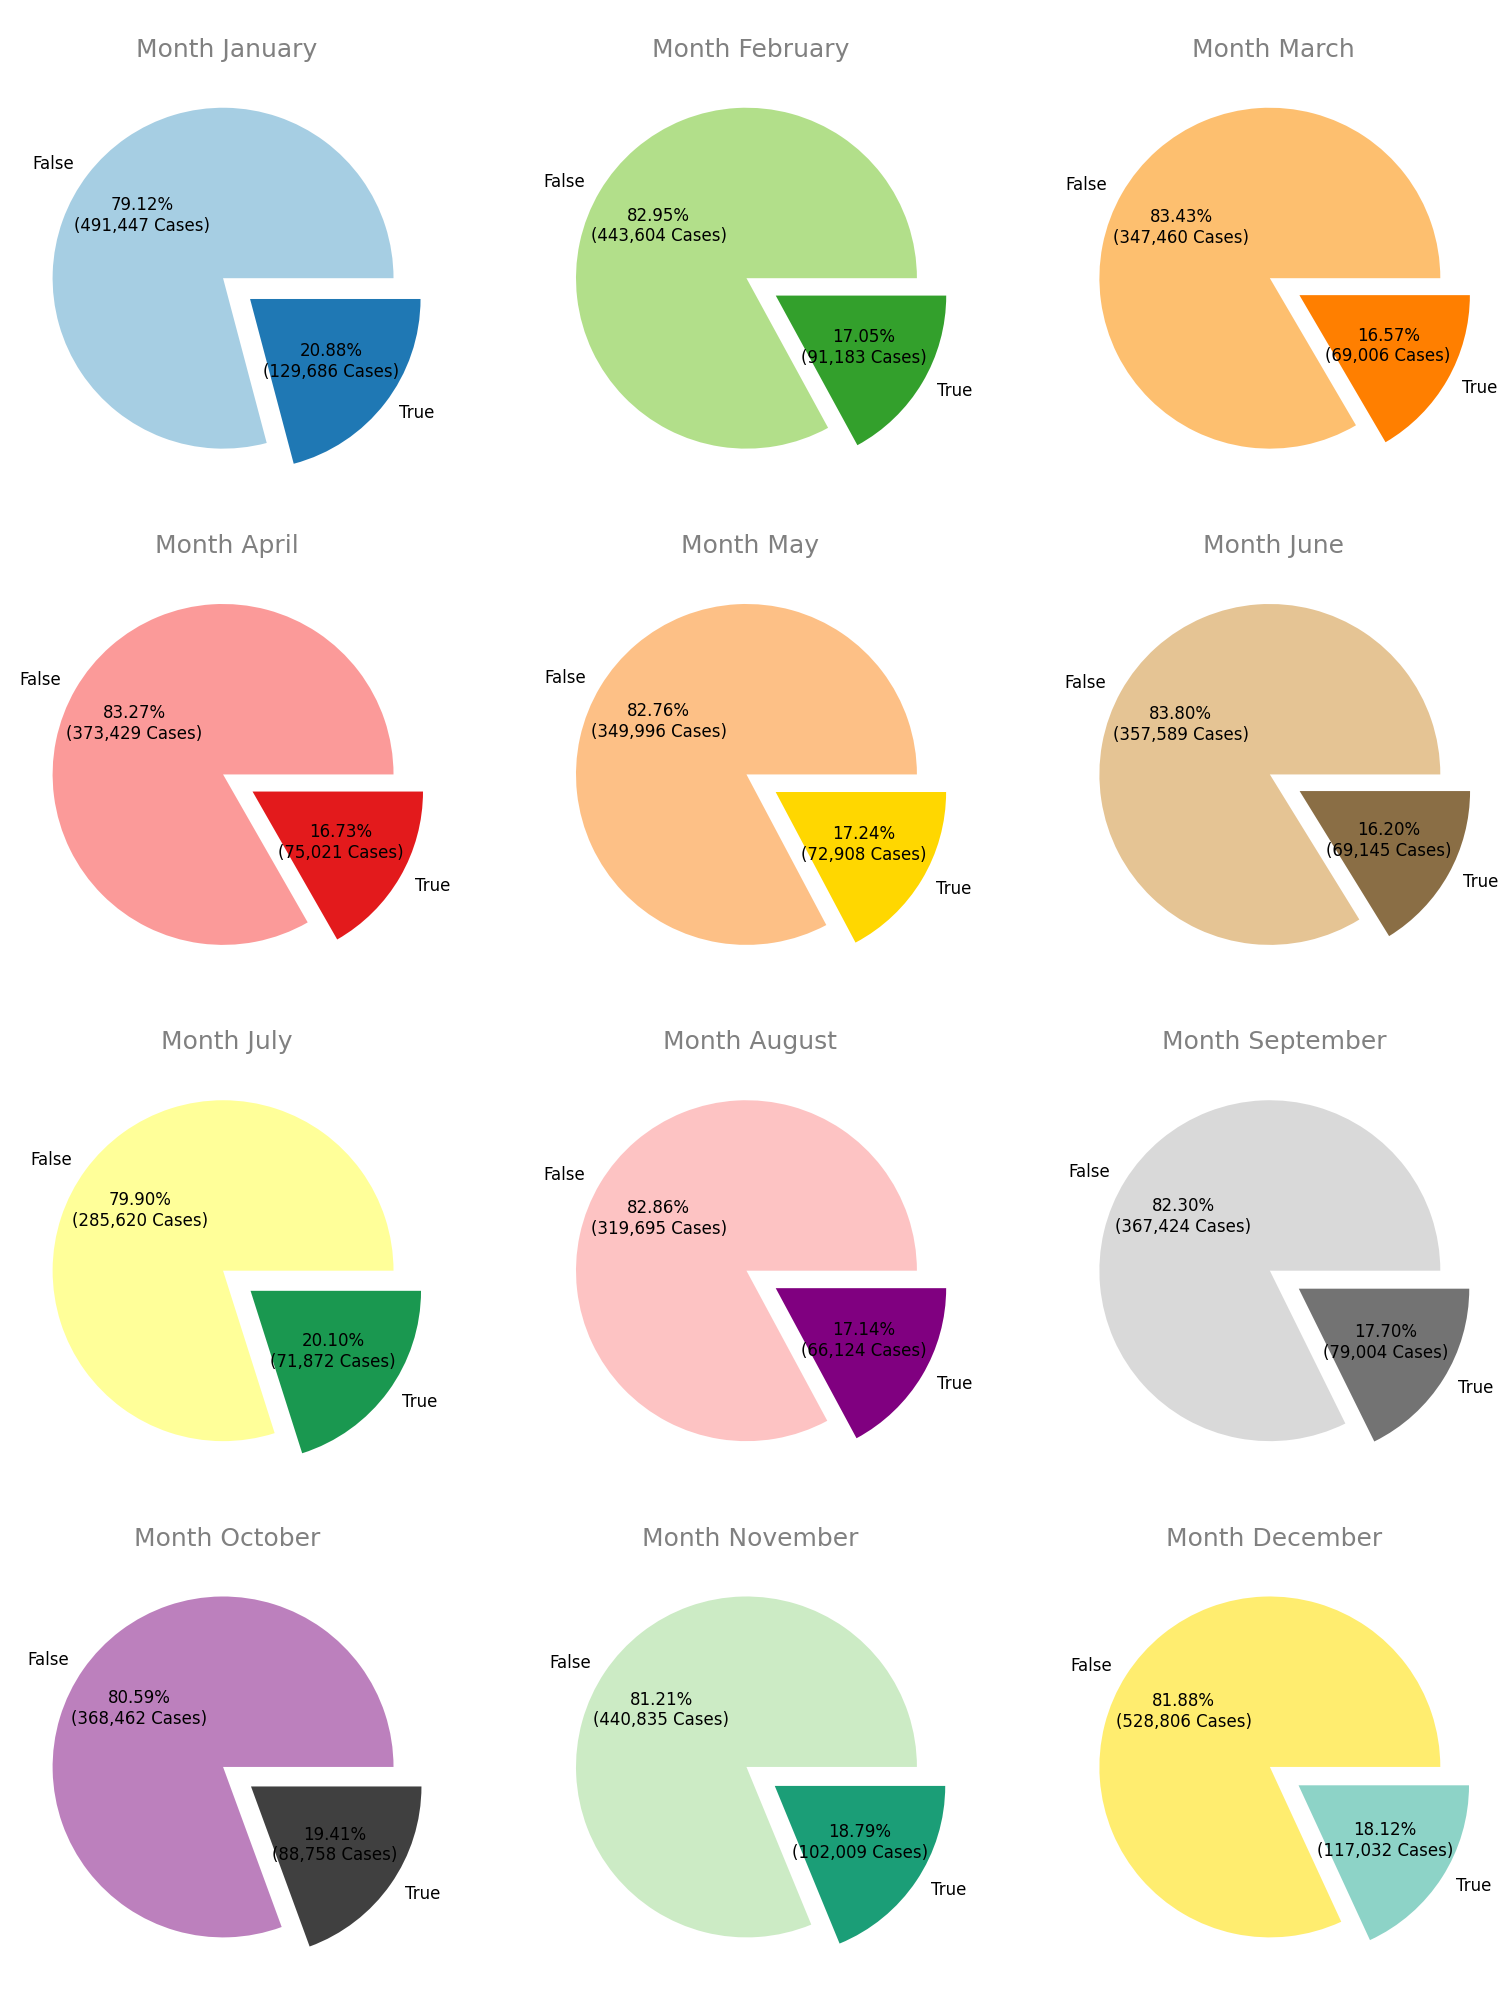

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

colors = [('#A6CEE3', '#1F78B4'), ('#B2DF8A', '#33A02C'), ('#FDBF6F', '#FF7F00'), ('#FB9A99', '#E31A1C'),
          ('#FDC086', '#FFD700'), ('#E5C494', '#8A6E45'), ('#FFFF99', '#1A9850'), ('#FDC3C3', '#800080'),
          ('#D9D9D9', '#737373'), ('#BC80BD', '#404040'), ('#CCEBC5', '#1B9E77'), ('#FFED6F', '#8DD3C7')]



count = 0

def func(pct, allvals):
    absolute = int(round(pct / 100 * np.sum(allvals), 2))
    return "{:.2f}%\n({:,d} Cases)".format(pct, absolute)

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    size = list(data[data["Month"] == month]["Is_Weekend"].value_counts())
    if len(size) != 2:
        size.append(0)

    labels = ['False', 'True']

    ax.pie(size, labels=labels, colors=colors[count],
           autopct=lambda pct: func(pct, size), labeldistance=1.1,
           textprops={'fontsize': 12}, explode=[0, 0.2])

    title = '\n Month {}'.format(month_map[month])

    ax.set_title(title, fontsize=18, color='grey')

    count += 1

plt.tight_layout()
plt.show()

## Analysing by time

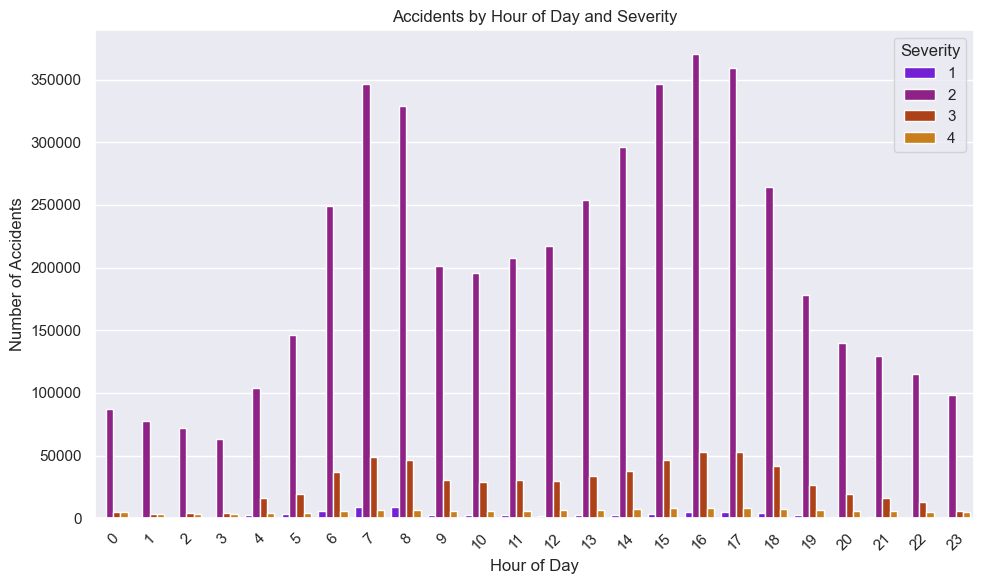

In [ ]:
# Set chart style
palette=sns.color_palette('gnuplot')
sns.set(style="darkgrid", palette="gnuplot", context="notebook",)

# Extract hour of day from 'Start_Time'
data['Hour_of_Day'] = data['Start_Time'].dt.hour

# Create a new dataset with 'Severity' and 'Hour_of_Day' columns
severity_hour_dataset = data[['Severity', 'Hour_of_Day']].copy()

# Task 3: Create a Seaborn countplot to visualize accidents by hour and severity
plt.figure(figsize=(10, 6))
sns.countplot(data=severity_hour_dataset, x='Hour_of_Day', hue='Severity', palette='gnuplot')
plt.title('Accidents by Hour of Day and Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

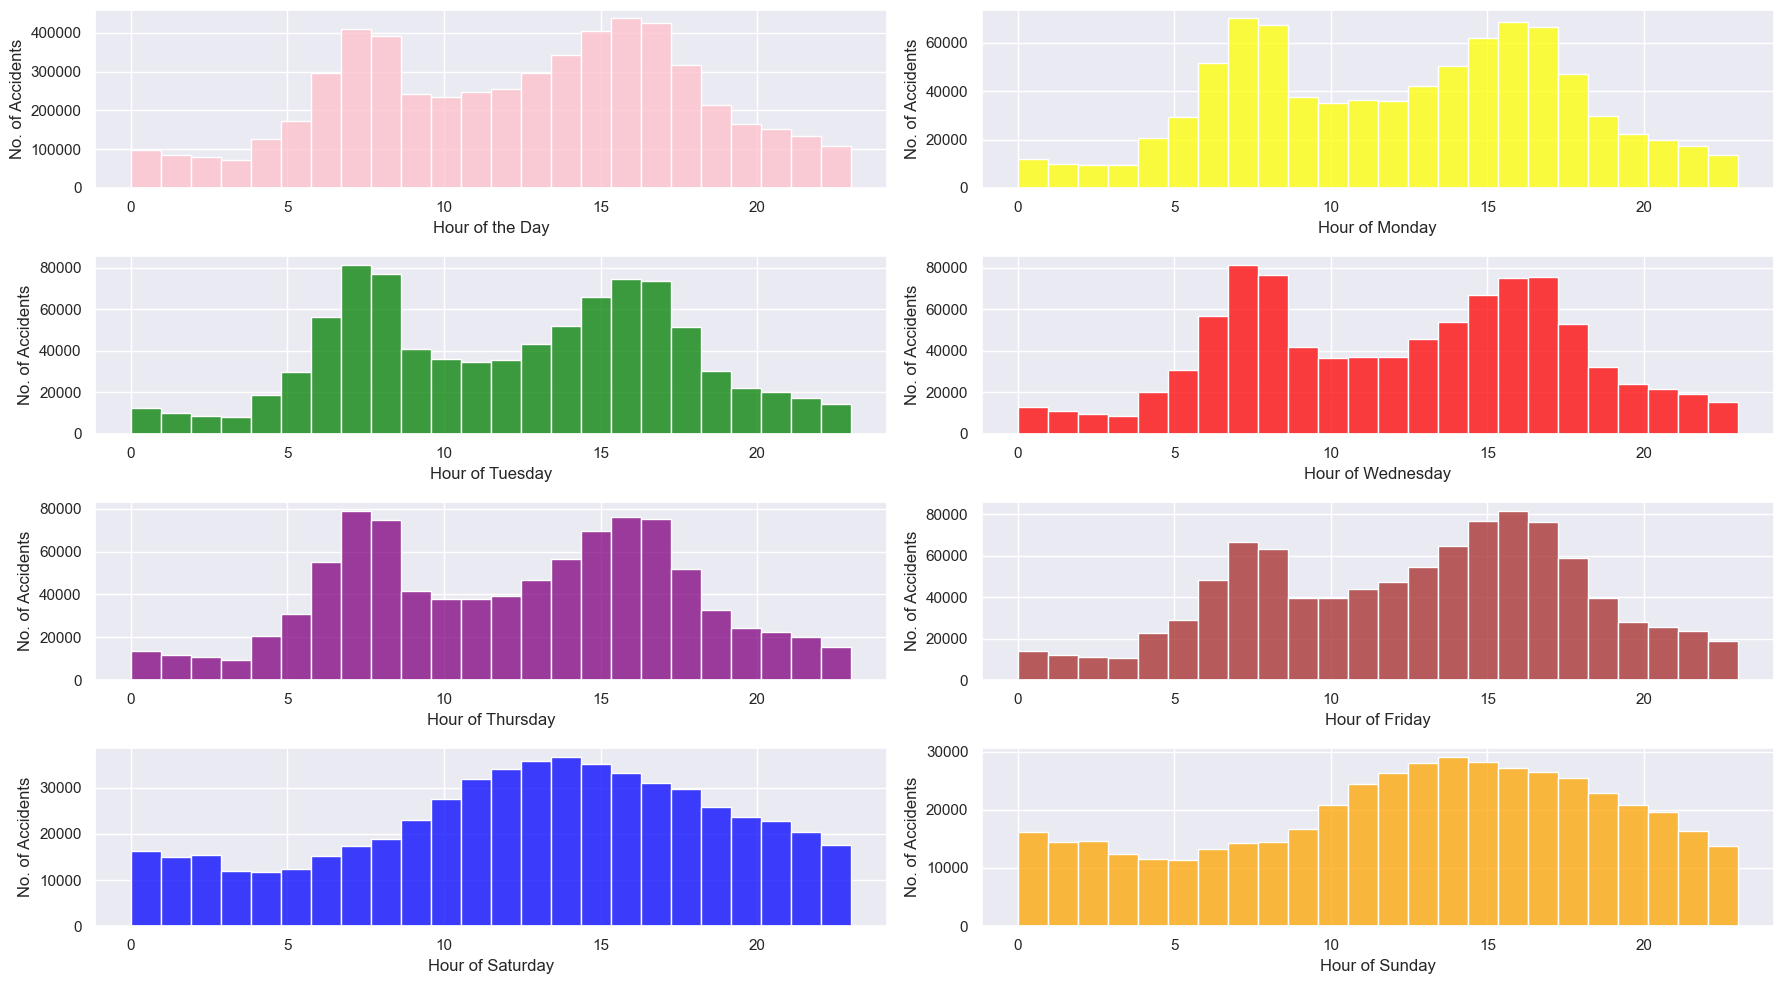

In [ ]:
# Viewing the distribution of  hourly Accidents for each day of week separately.

fig,axes = plt.subplots(4, 2, figsize=(18, 10))

#For all days (Overall) Hourly accident distribution
sns.histplot(data.Start_Time.dt.hour, bins=24, ax=axes[0,0], color = "Pink");
axes[0,0].set_xlabel("Hour of the Day")
axes[0,0].set_ylabel("No. of Accidents")

#For Monday Hourly accident distribution

For_Monday = data.Start_Time[data.Start_Time.dt.dayofweek == 0]
Monday_distribution = sns.histplot(For_Monday.dt.hour, bins = 24, ax = axes[0,1], color = "Yellow")
axes[0,1].set_xlabel("Hour of Monday")
axes[0,1].set_ylabel("No. of Accidents")


#For Tuesday Hourly accident distribution

For_Tuesday = data.Start_Time[data.Start_Time.dt.dayofweek == 1]
Tuesday_distribution = sns.histplot(For_Tuesday.dt.hour, bins = 24, ax = axes[1,0],  color = "green")
axes[1,0].set_xlabel("Hour of Tuesday")
axes[1,0].set_ylabel("No. of Accidents")

#For Wednesday Hourly accident distribution

For_Wednesday = data.Start_Time[data.Start_Time.dt.dayofweek == 2]
Wednesday_distribution = sns.histplot(For_Wednesday.dt.hour, bins = 24, ax = axes[1,1],  color = "Red")
axes[1,1].set_xlabel("Hour of Wednesday")
axes[1,1].set_ylabel("No. of Accidents")

#For Thursday Hourly accident distribution

For_Thursday = data.Start_Time[data.Start_Time.dt.dayofweek == 3]
Thursday_distribution = sns.histplot(For_Thursday.dt.hour, bins = 24, ax = axes[2,0],  color = "Purple")
axes[2,0].set_xlabel("Hour of Thursday")
axes[2,0].set_ylabel("No. of Accidents")

#For Friday Hourly accident distribution

For_Friday = data.Start_Time[data.Start_Time.dt.dayofweek == 4]
Friday_distribution = sns.histplot(For_Friday.dt.hour, bins = 24, ax = axes[2,1],  color = "Brown")
axes[2,1].set_xlabel("Hour of Friday")
axes[2,1].set_ylabel("No. of Accidents")

#For Saturday Hourly accident distribution

For_saturday = data.Start_Time[data.Start_Time.dt.dayofweek == 5]
Saturday_distribution = sns.histplot(For_saturday.dt.hour, bins = 24, ax = axes[3,0],  color = "Blue")
axes[3,0].set_xlabel("Hour of Saturday")
axes[3,0].set_ylabel("No. of Accidents")

#For Sunday Hourly accident distribution

For_Sunday = data.Start_Time[data.Start_Time.dt.dayofweek == 6]
Sunday_distribution = sns.histplot(For_Sunday.dt.hour, bins = 24, ax = axes[3,1], color = "Orange")
axes[3,1].set_xlabel("Hour of Sunday")
axes[3,1].set_ylabel("No. of Accidents")


plt.tight_layout()
plt.show()

## Insights
- There is a clear reduction in the number of accidents at weekends.
- January has the highest proportion of weekend accidents compared with weekday accidents, at 17.71%.
- Augusth has the lowest proportion of weekend accidents, at 3.258%
- December has the highest number of accidents.
- July has the lowest number of accidents.
- Max no of accidents are in the morning (6am -8am) and in evening (3pm -6pm). May be because it is the peak hour of the day as most people go out and return home from work place in this time only.
- The pattern of accident on weekends are different

###  Analysing weather condition

In [ ]:
len(data["Weather_Condition"].unique())

130

In [ ]:
data["Weather_Condition"].value_counts()

Weather_Condition
Fair                         2552561
Cloudy                        814346
Mostly Cloudy                 732557
Partly Cloudy                 503969
Light Rain                    259022
                              ...   
Heavy Rain Shower / Windy          1
Blowing Snow Nearby                1
Blowing Sand                       1
Partial Fog / Windy                1
Drifting Snow                      1
Name: count, Length: 129, dtype: int64

In [ ]:
#Selecting only top 15 weather conditions which accounted for maximum accidents
weather = data['Weather_Condition'].value_counts().sort_values(ascending = False).head(15)
weather

Weather_Condition
Fair                       2552561
Cloudy                      814346
Mostly Cloudy               732557
Partly Cloudy               503969
Light Rain                  259022
Light Snow                  102679
Fog                          89196
Clear                        65286
Rain                         62810
Overcast                     53482
Haze                         50709
Fair / Windy                 35513
Heavy Rain                   24326
Thunder in the Vicinity      17553
Cloudy / Windy               16974
Name: count, dtype: int64

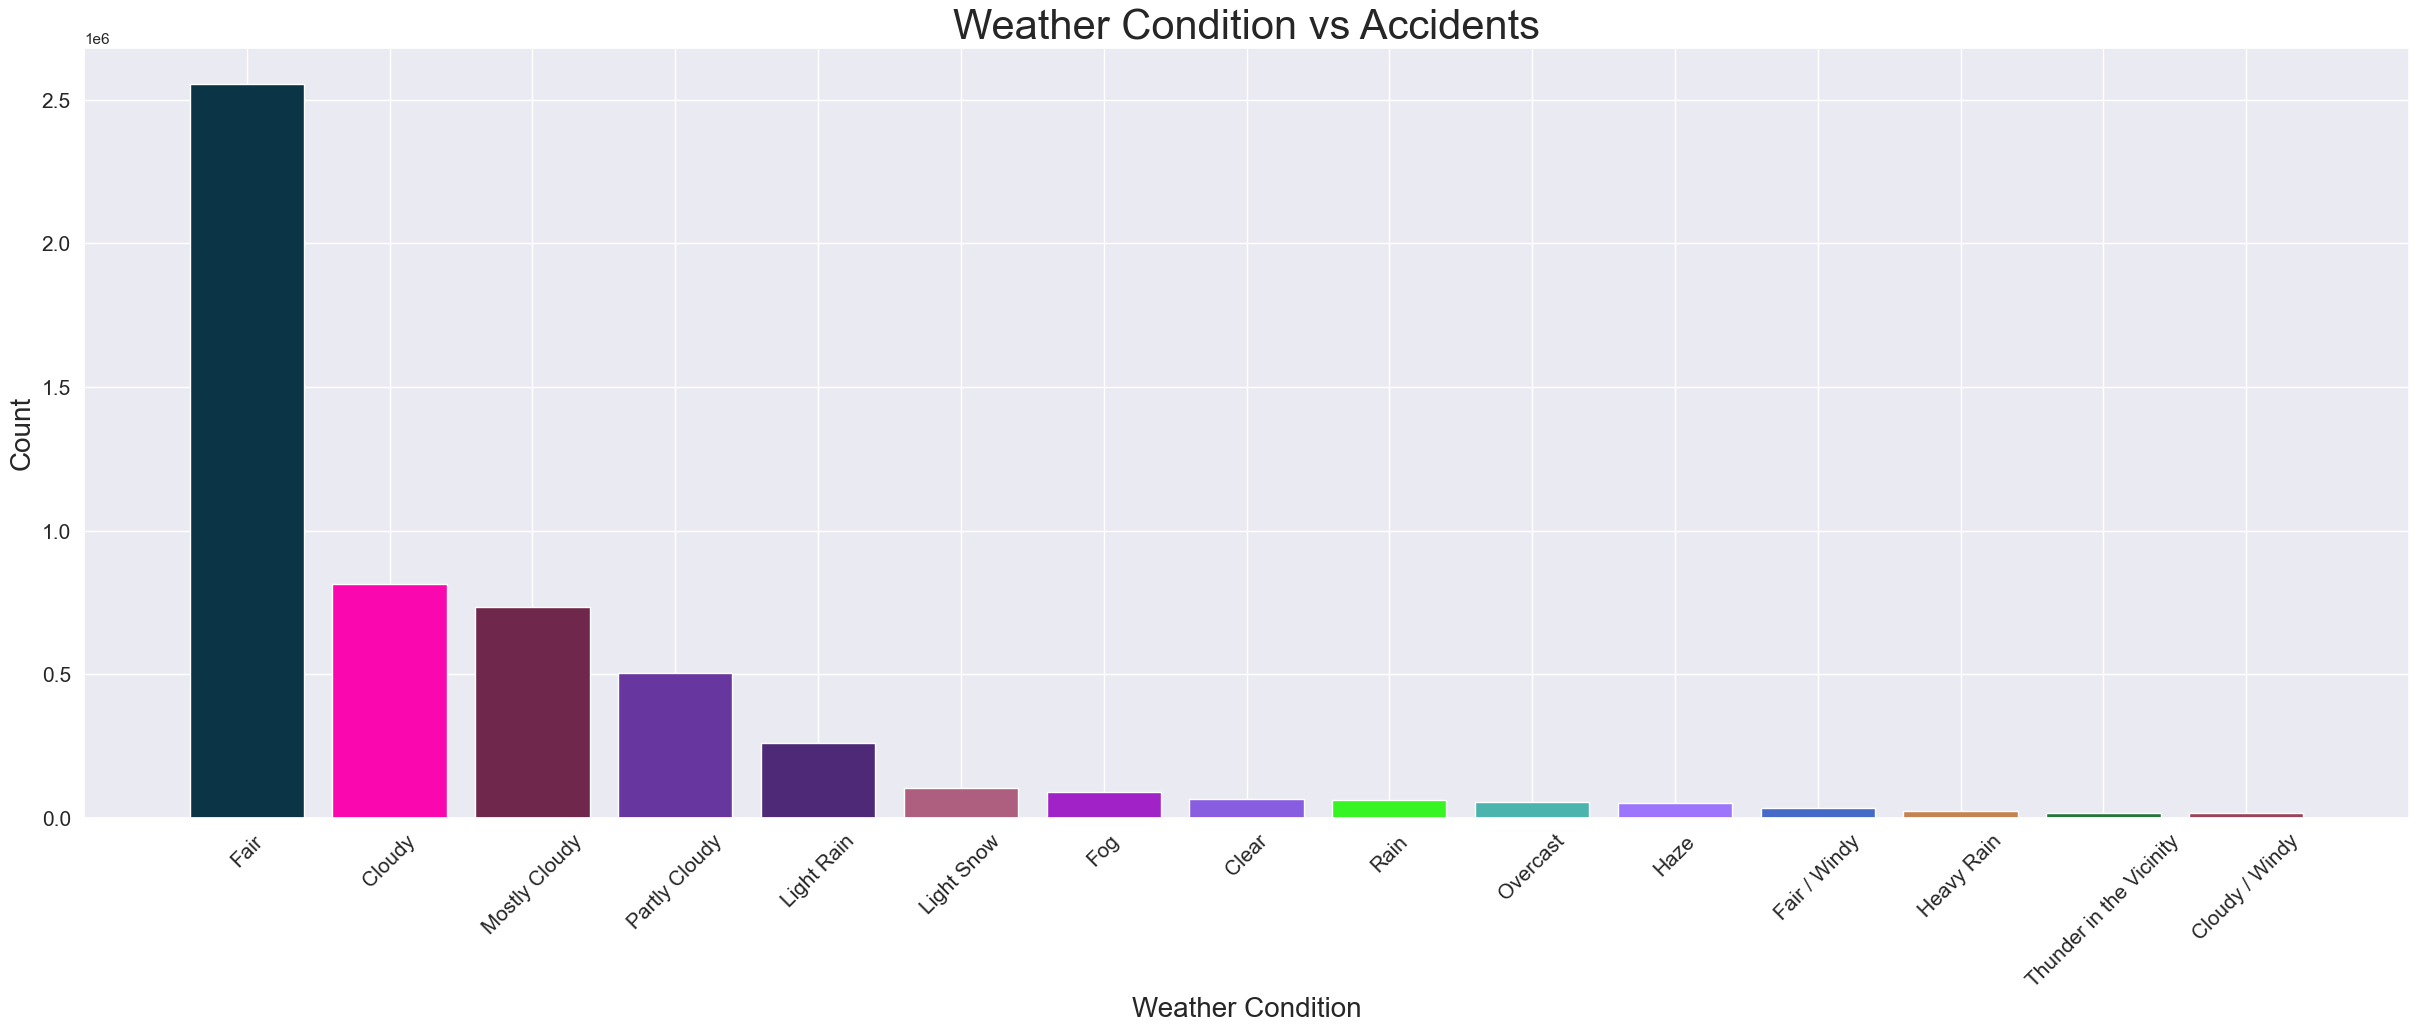

In [ ]:
import random
figsize = (30, 10)

Accident_Counts = weather.values
Weather_Conditions = weather.index
def generate_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

bar_colors = [generate_random_color() for _ in range(len(Weather_Conditions))]

plt.figure(figsize=figsize)

plt.bar(Weather_Conditions, Accident_Counts, color=bar_colors)
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Weather Condition", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Weather Condition vs Accidents", fontsize = 30)

plt.show()

## Insights
- Mostof the accidents have taken place in Fair, cloudy and clear day.
-  Very less accident on rainy, foggy days.
-   Probably because people travel more in clear, fair days and travel less in rainy days.

## Analysing by road

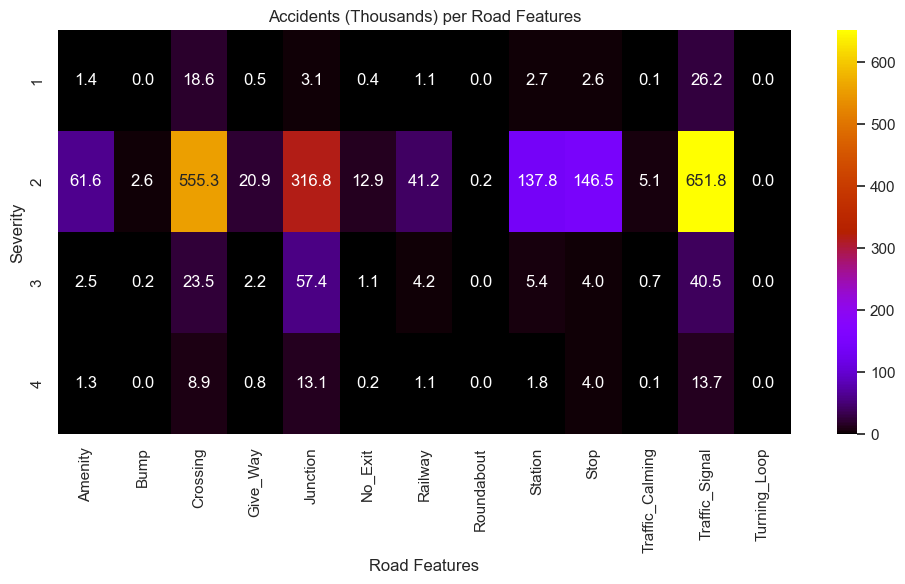

In [ ]:
# Create a new dataset with boolean columns and severity
bool_severity_dataset = data[['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                              'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                              'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].copy()

# Calculate the number of accidents for each combination of severity and boolean columns
accidents_by_bool_severity = bool_severity_dataset.groupby(['Severity']).sum()

# Create a heatmap to visualize the relationship between accident severity and boolean columns
plt.figure(figsize=(10, 6))
sns.heatmap(data=accidents_by_bool_severity/1000, cmap='gnuplot', annot=True, fmt='.1f')
plt.title('Accidents (Thousands) per Road Features')
plt.xlabel('Road Features')
plt.ylabel('Severity')
plt.tight_layout()

plt.show()

## Insights
From the correlation chart we can see that:

- Junctions, crossings and traffic signals tend to have most car accidents;
- Junctions and traffic signals tend to have the most severe accidents;
- Roundabouts and Turning Loops have the least accidents;

## Visualize accident hotspots

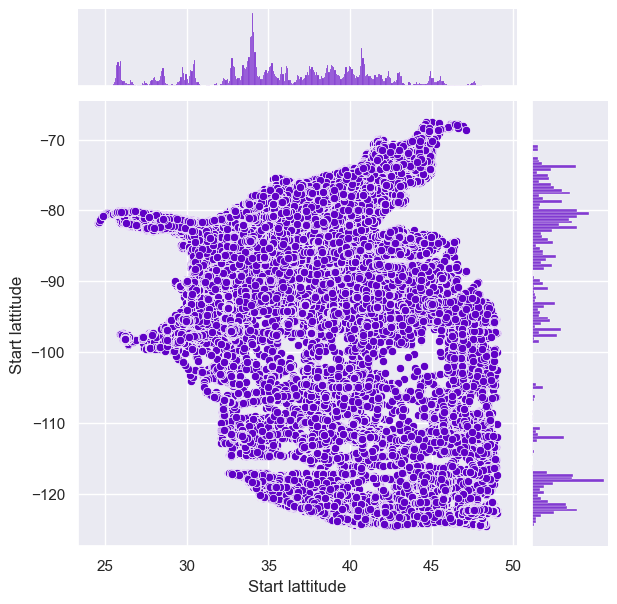

In [ ]:
#. Longitude and Latitude with Accidents Density
data_num=data.select_dtypes(np.number)
sns.jointplot(x=data_num.Start_Lat.values , y=data_num.Start_Lng.values,height=6)
plt.ylabel('Start lattitude', fontsize=12)
plt.xlabel('Start lattitude', fontsize=12)
plt.show()

## Predictive Modeling
- Having meticulously prepared our dataset, we proceeded to construct a predictive model using the XGBoost algorithm.
- XGBoost is known for its efficiency and accuracy, enabling us to unravel the intricate relationships between the myriad of features and the target variable—accident severity.
- We partitioned the preprocessed dataset into distinct training and testing sets to ensure the model's ability to generalize.
- Since we have a multi-class classification task, we need to set the model's objective to 'multi:softmax,' accommodating the grading of severity levels spanning 1 to 4. 4.

In [ ]:
data['Severity'] = data['Severity'].astype("int64")
data['Severity'] = data['Severity'] -1

data[['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
           'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
           'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']] = data[['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
           'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
           'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].astype('int')

# Separate the target variable from the features
y = data.pop('Severity')
X = data.copy()

# Split the data into train and test sets for both X and y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Columns to include in the pipeline
numeric_cols = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)',
                'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
                'Hour_of_Day', 'Duration_in_minutes',
                'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Create Categories
categories = ['Sunrise_Sunset',
              'Weather_Condition',
              'Wind_Direction',
              'State',
              'Month',
              'Time_of_Year',
              'Day',
              'City']

data[categories] = data[categories].astype('category')

categorical_cols = categories

# Step 2: Preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 3: Fit the model
xgb_model = XGBClassifier(objective='multi:softmax',
                          num_class=4,
                          random_state=42,
                          tree_method='gpu_hist'  # Enable GPU acceleration
                         )

# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Step 5: Make predictions
predictions = pipeline.predict(X_val)

### Model Results: Confusion Matrix

-  
Below we'll show a Confusion Matrix detailing how the model performed against the real data
- . Ideally, we would have a perfect bright diagonal, but as you can see below, the model misclassified many of the accidents as having Severity 2. This is something we can try to improve in the next steps.

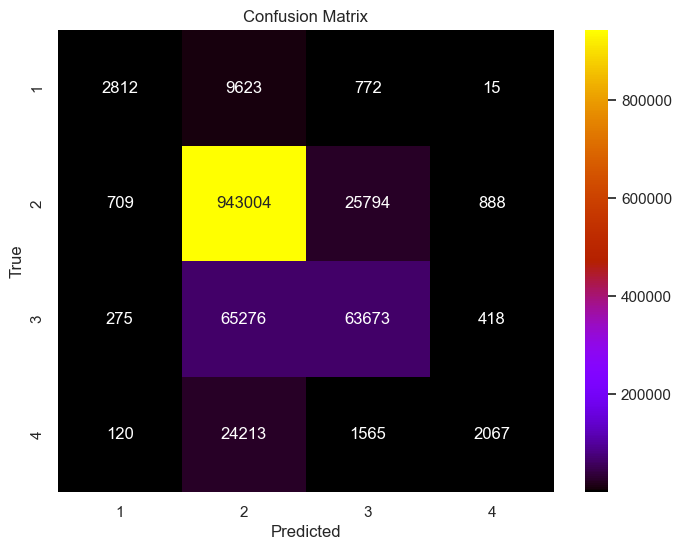

              precision    recall  f1-score   support

           1       0.72      0.21      0.33     13222
           2       0.90      0.97      0.94    970395
           3       0.69      0.49      0.58    129642
           4       0.61      0.07      0.13     27965

    accuracy                           0.89   1141224
   macro avg       0.73      0.44      0.49   1141224
weighted avg       0.87      0.89      0.87   1141224



In [ ]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_val, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_val, predictions, target_names=['1', '2', '3', '4'])
print(class_report)

## Model Improvement:
-  For optimization purposes, we will undertake the task of fine-tuning the model's hyperparameters and investigating the potential of L1 and L2 regularization to enhance the accuracy of predictions.
-  Given the substantial size of our dataset, the emphasis for now will be on these optimization steps, while temporarily setting aside the consideration of cross-validation.

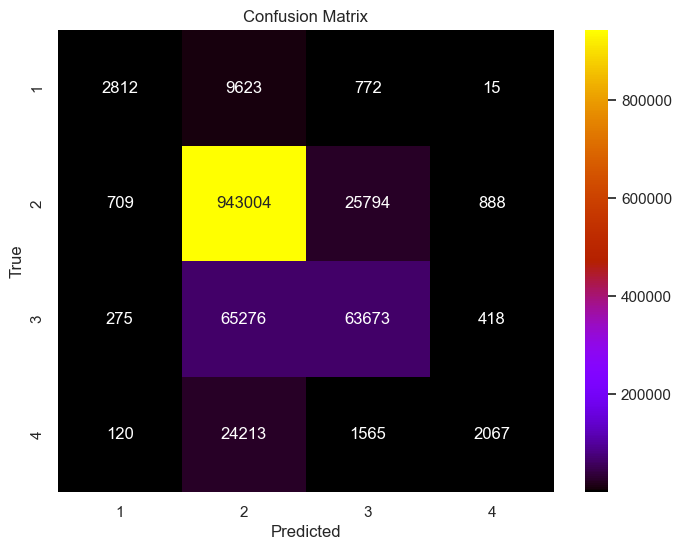

              precision    recall  f1-score   support

           0       0.94      0.08      0.14     13222
           1       0.88      0.99      0.93    970395
           2       0.74      0.29      0.42    129642
           3       0.98      0.01      0.01     27965

    accuracy                           0.87   1141224
   macro avg       0.88      0.34      0.38   1141224
weighted avg       0.87      0.87      0.84   1141224



In [ ]:
# Set new hyperparameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,  # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metric
    'eta': 0.01,  # Lower learning rate to encourage exploration
    'max_depth': 8,  # Deeper trees for more complex interactions
    'min_child_weight': 2,  # Increase minimum child weight for regularization
    'subsample': 0.7,  # Slightly decrease subsample ratio
    'colsample_bytree': 0.7,  # Slightly decrease column subsample ratio
    'gamma': 0.5,  # Increase minimum loss reduction for partitions
    'reg_alpha': 0.3,  # Regularization for L1
    'reg_lambda': 0.8,  # Keep L2 regularization moderate
    'tree_method': 'gpu_hist'  # Enable GPU acceleration
}

# Create the XGBoost model
new_model = XGBClassifier(**params)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', new_model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
new_predictions = pipeline.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the pipeline
print(classification_report(y_val, new_predictions))

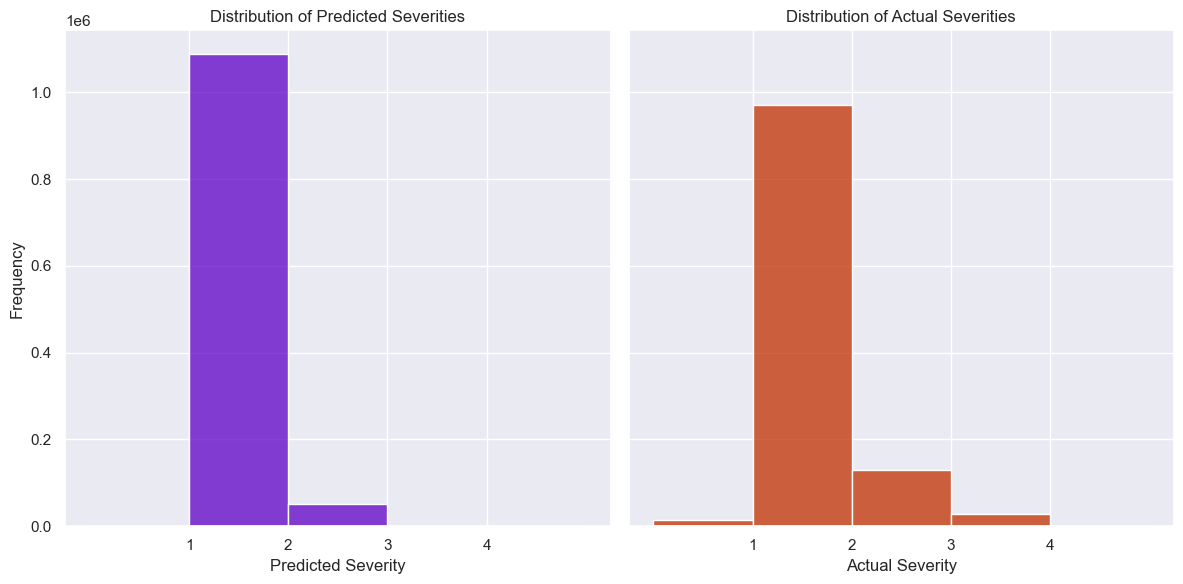

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the predicted distribution
sns.histplot(new_predictions, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[0], ax=axes[0])
axes[0].set_xlabel('Predicted Severity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Severities')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['1', '2', '3', '4'])

# Plot the actual distribution
sns.histplot(y_val, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[3], ax=axes[1])
axes[1].set_xlabel('Actual Severity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Actual Severities')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(['1', '2', '3', '4'])

plt.tight_layout()
plt.show()

## Performance Evaluation:
-  
Upon comparing the performances of both models, it appears that there is limited room for significant enhancement in the model's efficiency at this juncture
-  It's plausible that further iterations may benefit from additional feature engineering or refined fine-tuning to yield more substantial improvements. However, for the current iteration, these efforts conclude our optimization endeavorson.

#### As we conclude this notebook, we'll delve into the extraction of feature importances, shedding light on the factors that wielded significant influence over the algorithm's predictive outcomes. It's important to highlight that the weight of feature importances doesn't necessarily correlate with a higher severity rating; rather, these attributes proved to be more informative, aiding the algorithm in deciphering the intricacies of accident severity determination.

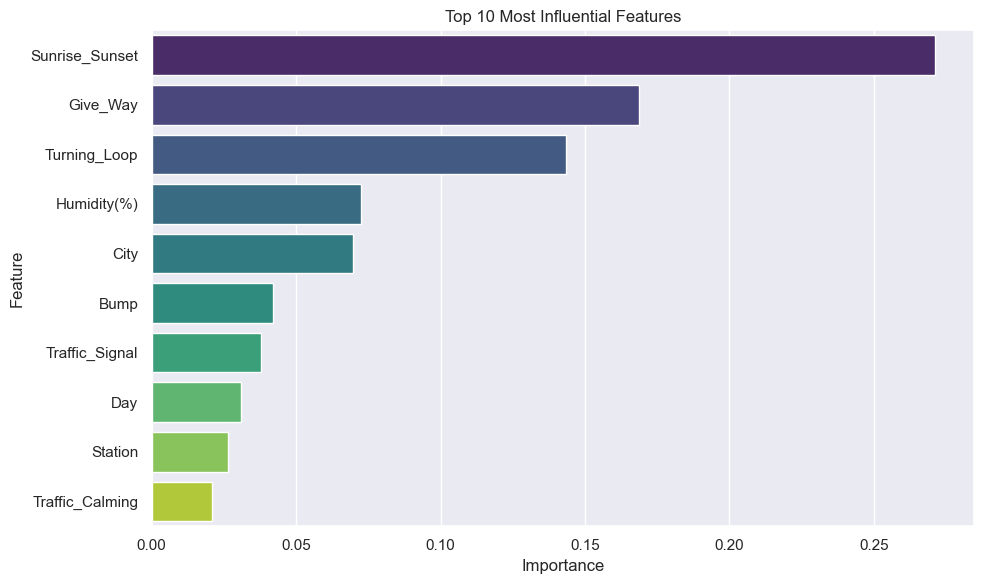

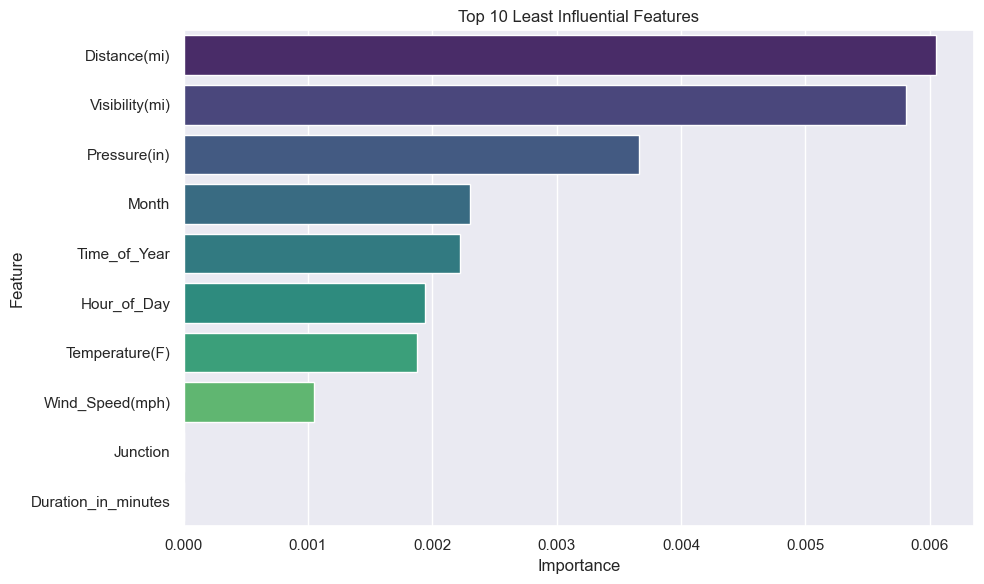

In [ ]:
# Get feature importances from the XGBoost model inside the pipeline
feature_importances = pipeline.named_steps['model'].feature_importances_

# Get the column names from the preprocessor
categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out()

all_feature_names = np.concatenate([categories, numeric_cols])

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Generate elegant Seaborn bar charts for most and least influential features
plt.figure(figsize=(10, 6))

# Most influential features
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Least influential features
sns.barplot(data=importance_df.tail(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Least Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

## Insights
'Sunsise-Sunset' ,'Give-way', 'Turning-loop', 'Humidity' are the most infuencing parameters for predicting severity of accident by using XGBoost